In [6]:
!nvidia-smi
%matplotlib inline

Thu Jun 26 20:18:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100                    On  |   00000000:A6:00.0 Off |                    0 |
| N/A   36C    P0            119W /  700W |   87973MiB /  95830MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [1]:
import pandas as pd
import json
import re
import numpy as np
from typing import List, Optional, Dict, Any
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
import torch

In [2]:
%matplotlib inline

# Loading files

In [8]:
# For Snellius
input_csv = "../data/few_shots.csv"
df_few_shots = pd.read_csv(input_csv)
real_csv = "../data/Test_1155.csv"
df_test_1155 = pd.read_csv(real_csv)
learning_csv = "../data/in-context_learning_set.csv"
df_in_context_learning = pd.read_csv(learning_csv)

# Prompt Setting

In [3]:
system_prompt = """
You are an expert analyst. Your task is to analyze and determine whether an input user query is "fully specified" or "underspecified".

"""

task_FS_UND = """
Analyze the following input user query:

{"query": "TARGET"}

Please provide your analysis in the following JSON format:

{"query": "TARGET", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}
"""

# For model loading

In [5]:
DSR1_1_5B = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
DSR1_7B = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
DSR1_14B = "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B"
DSR1_32B = "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B"

In [ ]:
"""
module load CUDA/12.4.0
source ~/sglang-venv-2/bin/activate
huggingface-cli login


# 创建所有必要的目录
mkdir -p /scratch-local/yhuang/sglang_cache
mkdir -p /scratch-local/yhuang/huggingface_cache
mkdir -p /scratch-local/yhuang/torch_cache
mkdir -p /scratch-local/yhuang/cuda_cache
mkdir -p /scratch-local/yhuang/xdg_cache
mkdir -p /scratch-local/yhuang/tmp
mkdir -p /scratch-local/yhuang/logs

# 设置所有相关环境变量
export SGLANG_CACHE_DIR=/scratch-local/yhuang/sglang_cache
export TRANSFORMERS_CACHE=/scratch-local/yhuang/huggingface_cache
export HF_HOME=/scratch-local/yhuang/huggingface_cache
export HF_DATASETS_CACHE=/scratch-local/yhuang/huggingface_cache/datasets
export TORCH_HOME=/scratch-local/yhuang/torch_cache
export CUDA_CACHE_PATH=/scratch-local/yhuang/cuda_cache
export XDG_CACHE_HOME=/scratch-local/yhuang/xdg_cache
export TMPDIR=/scratch-local/yhuang/tmp
export TEMP=/scratch-local/yhuang/tmp
export TMP=/scratch-local/yhuang/tmp
export SGLANG_LOG_DIR=/scratch-local/yhuang/logs

# launching
python -m sglang.launch_server --port 7501 --model-path deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B --trust-remote-code
python -m sglang.launch_server --port 7501 --model-path deepseek-ai/DeepSeek-R1-Distill-Qwen-7B --trust-remote-code
python -m sglang.launch_server --port 7501 --model-path deepseek-ai/DeepSeek-R1-Distill-Qwen-14B --trust-remote-code
CUDA_VISIBLE_DEVICES=0,1 python -m sglang.launch_server --port 7501 --model-path deepseek-ai/DeepSeek-R1-Distill-Qwen-32B --trust-remote-code --tp 2


"""

# Helper functions

In [4]:
import openai
import re
client = openai.Client(
    base_url="http://localhost:7501/v1", api_key="EMPTY")


def batch_generate_responses_openai(prompts, system_prompt=system_prompt,
                             temperature=0.7, max_new_tokens=32768, batch_size=5):
    responses = []
    thoughts = []

    for i in tqdm(range(0, len(prompts), batch_size)):
        batch_prompts = prompts[i:i+batch_size]
        batch_responses = []
        batch_thoughts = []

        for prompt in batch_prompts:
            try:
                response = client.chat.completions.create(
                    model="default",
                    messages=[
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": prompt},
                    ],
                    temperature=temperature,
                    max_tokens=max_new_tokens,
                )

                full_text = response.choices[0].message.content

                try:
                    # 查找结束标签位置
                    end_think_pos = full_text.find('</think>')

                    if end_think_pos != -1:
                        # 思考部分是从开始到</think>标签
                        thought = full_text[:end_think_pos].strip()
                        # 回答部分是</think>标签之后的内容
                        answer = full_text[end_think_pos + len('</think>'):].strip()
                    else:
                        # 没有找到思考标签，将整个回复视为答案
                        thought = ""
                        answer = full_text
                except Exception as parsing_error:
                    print(f"解析思考过程时出错: {parsing_error}")
                    thought = ""
                    answer = full_text  # 回退到完整回复

                batch_responses.append(answer)
                batch_thoughts.append(thought)

            except Exception as e:
                print(f"API调用时出错: {e}")
                batch_responses.append(None)
                batch_thoughts.append(None)

        responses.extend(batch_responses)
        thoughts.extend(batch_thoughts)

    return responses, thoughts

def run_experiment(input_prompts, test_df):
  output = batch_generate_responses_openai(input_prompts)
  df = test_df.copy()
  df['thinking'] = output[1]
  df['model_response'] = output[0]
  to_process = output[0]
  processed_judgments = get_judgments_from_responses(to_process)
  df['model_pred'] = processed_judgments

  return df

def get_judgments_from_responses(responses: List[str]) -> List[Optional[str]]:
    """
    推荐的解析函数，结合了多种方法的优点
    """
    judgments = []

    for i, response in enumerate(responses):
        judgment = None

        try:
            # 方法1: 尝试直接解析JSON
            clean_response = response.strip()
            if clean_response.startswith('{') and clean_response.endswith('}'):
                data = json.loads(clean_response)
                judgment = data.get('judgment')
            else:
                # 方法2: 寻找JSON部分
                start_idx = clean_response.find('{')
                end_idx = clean_response.rfind('}')
                if start_idx != -1 and end_idx != -1:
                    json_part = clean_response[start_idx:end_idx+1]
                    data = json.loads(json_part)
                    judgment = data.get('judgment')

        except json.JSONDecodeError:
            # 方法3: 使用正则表达式作为后备
            pattern = r'"judgment"\s*:\s*"([^"]*)"'
            match = re.search(pattern, response)
            if match:
                judgment = match.group(1)

        if judgment is None:
            print(f"Warning: response {i} cannot retrieve judgment")
            print(f"Respond content: {response[:200]}...")
            judgment = "error"

        judgments.append(judgment)

    return judgments

def retrieve_results(result_df, output_name):
  processed_judgments = result_df['model_pred'].tolist()

  if "error" in processed_judgments:
    print("There are unrecognized labels.")
    result_df.to_csv(f'{output_name}_error.csv')
  else:
    print("No error found, directly process the data.")
    print(classification_report(result_df["gold_judgment"], result_df['model_pred']))
    result_df.to_csv(f'{output_name}.csv')

    judgment_gold = result_df['gold_judgment'].tolist()
    judgment_model = result_df["model_pred"].tolist()

    binary_labels = ['underspecified', 'fully specified']

    cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

    disp.plot(cmap='Blues')  # 可以调整 colormap

def prepare_test_prompts(test_df, task_text, learning_df=None, instruction_text=None, theory=False):
  print("Start preparing prompts...")
  if learning_df is not None and instruction_text is not None:
    print(f"# learning samples: {len(learning_df)}")
    examples = []
    if theory:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "reasoning": row['reasoning'],
                "category": row['category'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text
    else:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text

  else:
    base_prompt = task_text

  print(f"# Testing data points: {len(test_df)}")
  test_prompts = []
  for _, row in test_df.iterrows():
    query = row['request']
    complete_prompt = base_prompt.replace("TARGET", query)
    test_prompts.append(complete_prompt)

  print(f"Generation complete: {len(test_prompts)} prompts")

  avg_length = sum(len(p) for p in test_prompts) // len(test_prompts)
  print(f"Average prompt length: {avg_length:,} bytes (~{avg_length//4:,} tokens)")

  return test_prompts

## DeepSeek 1.5B

## pilot

In [7]:
test_prompts = prepare_test_prompts(df_few_shots, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 12
Generation complete: 12 prompts
Average prompt length: 349 bytes (~87 tokens)

Analyze the following input user query:

{"query": "When did the nuclear accident happen?"}

Please provide your analysis in the following JSON format:

{"query": "When did the nuclear accident happen?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [8]:
test_df = run_experiment(test_prompts, df_few_shots)
test_df

100%|██████████| 3/3 [00:22<00:00,  7.58s/it]

Respond content: ```json
{"query": "Find the top five best selling video games of last year.", "reasoning": "The query specifically asks for the top five best selling video games from last year but lacks information a...


,request,gold_analysis,gold_thought,gold_category,gold_judgment,direct_source,thinking,model_response,model_pred
0,When did the nuclear accident happen?,"{""predicate"": ""happen"", ""argument_time"": ""when...","The predicate ""happen"" is specified; its argum...",underspecified referential/indexical argument,underspecified,CoCoNot,"Okay, so I need to determine whether the user ...","{""query"": ""When did the nuclear accident happe...",underspecified
1,I need help picking out a professional wardrob...,"{""predicate"": ""provide"", ""argument_agent"": ""yo...","The predicate ""provide"" is specified; its argu...",underspecified quantified argument,underspecified,IN3,"Okay, I need to determine if the user's query ...","{""query"": ""I need help picking out a professio...",underspecified
2,When did the apple tv 4k come out?,"{""predicate"": ""come out"", ""argument_time"": ""wh...","The predicate ""come out"" is underspecified bec...",underspecified predicate,underspecified,AmbigQA,"Alright, let me try to work through this. The ...","```json\n{\n ""query"": ""When did the Apple T...",underspecified
3,Who sings i love rock 'n' roll? ...,"{""predicate"": ""sings"", ""argument_agent"": ""who""...","The predicate ""sings"" is specified; its argume...",underspecified argument concept,underspecified,AmbigQA,"Alright, so I'm presented with this user query...","```json\n{\n ""query"": ""Who sings i love rock ...",underspecified
4,Where does the new fallout game take place?,"{""predicate"": ""take place"", ""argument_location...","The predicate ""take place"" is underspecified b...",multi-sourced underspecification,underspecified,AmbigQA,"Okay, so I need to figure out whether the user...","```json\n{\n ""query"": ""Where does the new fal...",fully specified
5,Who is the existing prime minister?,"{""predicate"": ""existing prime minister"", ""argu...","The predicate ""existing prime minister"" is spe...",missing argument,underspecified,CoCoNot,"Okay, so I need to figure out if the user quer...","```json\n{\n ""query"": ""Who is the existing pr...",fully specified
6,Who played the king in game of thrones season 1?,"{""predicate"": ""played"", ""argument_agent"": ""who...","The predicate ""played"" is specified; its argum...",fully specified request,fully specified,AmbigQA,"Alright, I'm looking at this user query: ""Who ...","```json\n{\n ""query"": ""Who played the king in...",underspecified
7,Who plays henry tudor in the white princess?,"{""predicate"": ""plays"", ""argument_agent"": ""who""...","The predicate ""plays"" is specified; its argume...",fully specified request,fully specified,AmbigQA,"Alright, I need to figure out if the user quer...","```json\n{\n ""query"": ""Who plays henry tudor ...",underspecified
8,Who won the contest to design the capitol buil...,"{""predicate"": ""won"", ""argument_agent"": ""who"", ...","The predicate ""won"" is specified; its argument...",fully specified request,fully specified,AmbigQA,"Okay, let me try to figure this out. The user ...","{""query"": ""Who won the contest to design the c...",underspecified
9,How many daughters do George Washington have?,"{""predicate: ""have"", ""argument_theme"": ""how ma...","The predicate ""have"" is specified; its argumen...",fully specified request,fully specified,IN3,"Alright, let me try to figure out how to appro...","```json\n{\n ""query"": ""How many daughters do ...",fully specified


In [9]:
retrieve_results(test_df, "DS1_5B_FS_UND_pilot")

There are unrecognized labels.


## implementation

In [10]:
test_prompts = prepare_test_prompts(df_test_1155, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 1155
Generation complete: 1155 prompts
Average prompt length: 341 bytes (~85 tokens)

Analyze the following input user query:

{"query": "The idea that the united states was destined to extend westward across the continent?"}

Please provide your analysis in the following JSON format:

{"query": "The idea that the united states was destined to extend westward across the continent?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [11]:
test_df = run_experiment(test_prompts, df_test_1155)
test_df

100%|██████████| 231/231 [42:54<00:00, 11.14s/it] 

Respond content: ```json
{"query": "When a blood vessel is injured the first phase in hemostasis to occur is?", "reasoning": "The query does not specify the type of blood vessel or the phase of hemostasis (acute, acut...
Respond content: Okay, I need to determine whether the user query "What geographical feature of the ocean floor is between the shoreline and the continental slope?" is fully specified or underspecified. 

First, I'll ...
Respond content: {"query": "Who plays klaus in a series of unfortunate events netflix?", "reasoning": "The query is underspecified because it does not include the title of the Netflix series or show. Without this info...
Respond content: ```json
{
  "query": "Who won the battle of blackburn's ford?",
  "reasoning": "The query is underspecified because it lacks clarity and specificity. The pronoun 'who' is vague, and the location is no...
Respond content: ```json
{"query": "Who DIED in the book into thin air?", "reasoning": "The query asks who died in t

,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
0,1787,The idea that the united states was destined t...,fully specified,AmbigQA,"Alright, so I'm trying to figure out if the us...","```json\n{\n ""query"": ""The idea that the unit...",underspecified
1,161,How many times french won the world cup?,fully specified,AmbigQA,"Alright, so I need to figure out if the user q...","```json\n{\n ""query"": ""How many times France ...",underspecified
2,1383,When was pink floyd's dark side of the moon re...,fully specified,AmbigQA,"Okay, I need to figure out if the user query i...","```json\n{\n ""query"": ""When was pink floyd's ...",underspecified
3,1111,When did leonardo da vinci finish painting the...,fully specified,AmbigQA,"Okay, I need to figure out whether the user qu...","```json\n{\n ""query"": ""When did leonardo da v...",underspecified
4,1542,Who is the first speaker of national assembly ...,fully specified,AmbigQA,"Okay, so I'm trying to figure out if this user...","{""query"": ""Who is the first speaker of nationa...",fully specified
...,...,...,...,...,...,...,...
1150,335,Is Pensacola sylvestris a multicellular organi...,fully specified,CLAMBER,"Okay, so I need to determine whether the user ...","{""query"": ""Is Pensacola sylvestris a multicell...",fully specified
1151,337,What's the leaf mass per area of Larrea divari...,fully specified,CLAMBER,"Okay, so I have this user query here: ""What's ...","{""query"": ""What's the leaf mass per area of La...",underspecified
1152,364,When did Patsyella make its last appearance in...,fully specified,CLAMBER,"Alright, I need to determine if the user query...","```json\n{\n ""query"": ""When did Patsyella mak...",fully specified
1153,276,What's the body mass of Salamandra salamandra?,fully specified,CLAMBER,"Alright, let me try to figure out whether the ...","{""query"": ""What's the body mass of Salamandra ...",underspecified


In [12]:
retrieve_results(test_df, "DS1_5B_FS_UND")

There are unrecognized labels.


                 precision    recall  f1-score   support

fully specified       0.59      0.19      0.29       598
 underspecified       0.50      0.86      0.63       557

       accuracy                           0.51      1155
      macro avg       0.55      0.53      0.46      1155
   weighted avg       0.55      0.51      0.46      1155



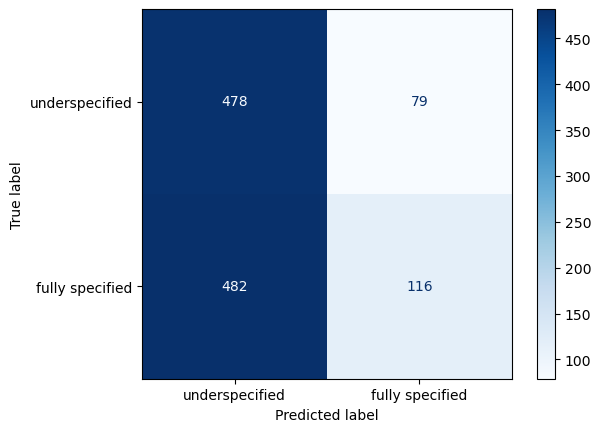

In [11]:
# If there are errors

result_df = pd.read_csv("DS1_5B_FS_UND_corrected.csv")

print(classification_report(result_df["gold_judgment"], result_df['model_pred']))


judgment_gold = result_df['gold_judgment'].tolist()
judgment_model = result_df["model_pred"].tolist()

binary_labels = ['underspecified', 'fully specified']

cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

disp.plot(cmap='Blues')  # 可以调整 colormap

In [4]:
def obtain_results_without(input_csv, filter_set):
    result_df = pd.read_csv(input_csv)
    result_df = result_df[result_df['direct_source']!=filter_set]
    print(classification_report(result_df["gold_judgment"], result_df['model_pred']))
    
    judgment_gold = result_df['gold_judgment'].tolist()
    judgment_model = result_df["model_pred"].tolist()
    binary_labels = ['underspecified', 'fully specified']

    cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

    disp.plot(cmap='Blues')  # 可以调整 colormap

                 precision    recall  f1-score   support

fully specified       0.64      0.22      0.33       431
 underspecified       0.52      0.88      0.66       424

       accuracy                           0.55       855
      macro avg       0.58      0.55      0.49       855
   weighted avg       0.58      0.55      0.49       855



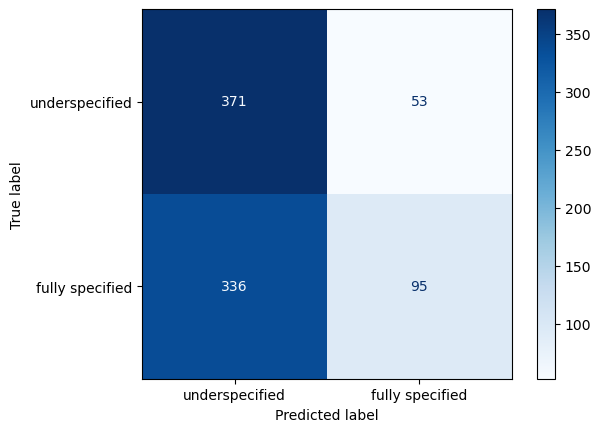

In [6]:
obtain_results_without("DS1_5B_FS_UND_corrected.csv", 'AmbigQA')

# DeepSeek 7B

In [7]:
test_prompts = prepare_test_prompts(df_test_1155, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 1155
Generation complete: 1155 prompts
Average prompt length: 341 bytes (~85 tokens)

Analyze the following input user query:

{"query": "The idea that the united states was destined to extend westward across the continent?"}

Please provide your analysis in the following JSON format:

{"query": "The idea that the united states was destined to extend westward across the continent?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [8]:
test_df = run_experiment(test_prompts, df_test_1155)
test_df

100%|██████████| 231/231 [2:00:59<00:00, 31.42s/it]

Respond content: {"query": "What was the name of bangladesh before independence?", "reasoning": "The query is fully specified as it asks for the name of Bangladesh before independence, which is 'East Pakistan'."}...
Respond content: **Analysis of the User Query:**

The query in question is: "When is the new series of doctor who coming on?" 

1. **Understanding the Query:**
   - The user is inquiring about the upcoming release of ...
Respond content: The input user query is:

**"Provide the latest global news updates."**

### Analysis:
The query asks for the latest news updates globally. However, it lacks specific details such as:
- **Scope**: Are...
Respond content: The user query is fully specified. 

**Reasoning:** The query clearly asks for a bulleted list of the top five most followed Instagram profiles, specifying both the format (bulleted list) and the cont...
Respond content: The query "What engine is in the Audi R8 V10?" is fully specified. 

**Reasoning:** The query provides t

,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
0,1787,The idea that the united states was destined t...,fully specified,AmbigQA,"Okay, so I need to figure out if the user's qu...","```json\n{\n ""query"": ""The idea that the unit...",underspecified
1,161,How many times french won the world cup?,fully specified,AmbigQA,"Alright, so I'm trying to figure out whether t...","```json\n{\n ""query"": ""How many times french ...",fully specified
2,1383,When was pink floyd's dark side of the moon re...,fully specified,AmbigQA,"Okay, so I have this query: ""When was pink flo...","```json\n{\n ""query"": ""When was pink floyd's ...",fully specified
3,1111,When did leonardo da vinci finish painting the...,fully specified,AmbigQA,"Okay, so I need to determine if the user query...","```json\n{\n ""query"": ""When did leonardo da v...",fully specified
4,1542,Who is the first speaker of national assembly ...,fully specified,AmbigQA,"Okay, I need to determine if the user's query ...","```json\n{\n ""query"": ""Who is the first speak...",fully specified
...,...,...,...,...,...,...,...
1150,335,Is Pensacola sylvestris a multicellular organi...,fully specified,CLAMBER,"Okay, so I need to figure out whether the user...","{""query"": ""Is Pensacola sylvestris a multicell...",fully specified
1151,337,What's the leaf mass per area of Larrea divari...,fully specified,CLAMBER,"Alright, so I need to determine whether the us...","{""query"": ""What's the leaf mass per area of La...",fully specified
1152,364,When did Patsyella make its last appearance in...,fully specified,CLAMBER,"Alright, let me try to figure out whether the ...","{""query"": ""When did Patsyella make its last ap...",underspecified
1153,276,What's the body mass of Salamandra salamandra?,fully specified,CLAMBER,"Okay, so I need to figure out whether the user...","```json\n{\n ""query"": ""What's the body mass o...",fully specified


In [9]:
retrieve_results(test_df, "DS7B_FS_UND")

There are unrecognized labels.


                 precision    recall  f1-score   support

fully specified       0.61      0.59      0.60       598
 underspecified       0.57      0.60      0.59       557

       accuracy                           0.59      1155
      macro avg       0.59      0.59      0.59      1155
   weighted avg       0.59      0.59      0.59      1155



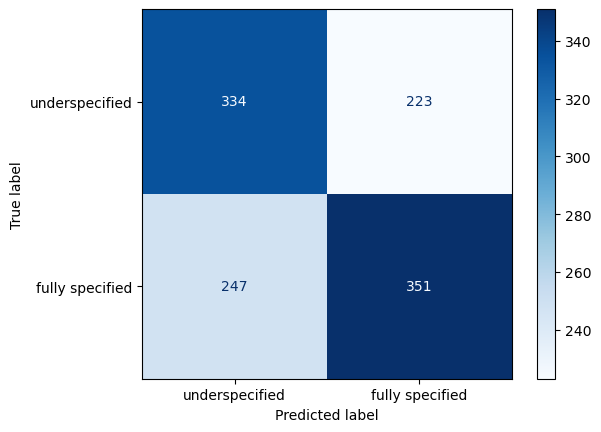

In [11]:
# If there are errors

result_df = pd.read_csv("DS7B_FS_UND_corrected.csv")

print(classification_report(result_df["gold_judgment"], result_df['model_pred']))


judgment_gold = result_df['gold_judgment'].tolist()
judgment_model = result_df["model_pred"].tolist()

binary_labels = ['underspecified', 'fully specified']

cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

disp.plot(cmap='Blues')  # 可以调整 colormap

                 precision    recall  f1-score   support

fully specified       0.63      0.62      0.62       431
 underspecified       0.62      0.63      0.62       424

       accuracy                           0.62       855
      macro avg       0.62      0.62      0.62       855
   weighted avg       0.62      0.62      0.62       855



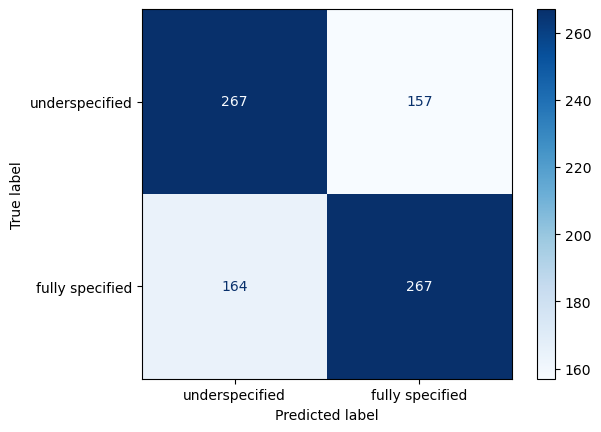

In [7]:
obtain_results_without("DS7B_FS_UND_corrected.csv", 'AmbigQA')

# DeepSeek 14B

In [8]:
test_prompts = prepare_test_prompts(df_test_1155, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 1155
Generation complete: 1155 prompts
Average prompt length: 341 bytes (~85 tokens)

Analyze the following input user query:

{"query": "The idea that the united states was destined to extend westward across the continent?"}

Please provide your analysis in the following JSON format:

{"query": "The idea that the united states was destined to extend westward across the continent?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [9]:
test_df = run_experiment(test_prompts, df_test_1155)
test_df

100%|██████████| 231/231 [2:21:24<00:00, 36.73s/it]  

Respond content: The user query "Who plays chef jeff on switched at birth?" is underspecified. 

**Reasoning**: The query asks about a character named Chef Jeff in the TV show "Switched at Birth." However, from my kno...
Respond content: **Analysis of User Query:**

The user query is "Who the female singer on gimme shelter?" 

- **Understanding the Query:** The user is inquiring about the female singer featured on the song "Gimme Shel...
Respond content: **Analysis of User Query:**

- **Query:** "Find an online course that will help me to learn Python programming."

- **Reasoning:**
  - The user hasn't specified their experience level in Python, which...
Respond content: **Analysis of User Query:**

- **Query:** "I need to create a study schedule for my upcoming university exams. Can you develop a personalized timetable for me?"
- **Subject and Courses:** Not specifie...
Respond content: **Analysis of the User Query**

The user query is: "I'm interested in classic literature. Could you

,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
0,1787,The idea that the united states was destined t...,fully specified,AmbigQA,"Alright, so I'm trying to figure out if the us...","{""query"": ""The idea that the united states was...",fully specified
1,161,How many times french won the world cup?,fully specified,AmbigQA,"Okay, so I need to determine if the query ""How...","```json\n{\n ""query"": ""How many times french ...",fully specified
2,1383,When was pink floyd's dark side of the moon re...,fully specified,AmbigQA,"Okay, let's break this down. The user is askin...","```json\n{\n ""query"": ""When was pink floyd's ...",fully specified
3,1111,When did leonardo da vinci finish painting the...,fully specified,AmbigQA,"Alright, let's dive into analyzing this query....","```json\n{\n ""query"": ""When did leonardo da v...",underspecified
4,1542,Who is the first speaker of national assembly ...,fully specified,AmbigQA,"Alright, so I need to figure out whether the q...","```json\n{\n ""query"": ""Who is the first speak...",fully specified
...,...,...,...,...,...,...,...
1150,335,Is Pensacola sylvestris a multicellular organi...,fully specified,CLAMBER,"Alright, so I need to figure out whether the u...","```json\n{\n ""query"": ""Is Pensacola sylvestri...",fully specified
1151,337,What's the leaf mass per area of Larrea divari...,fully specified,CLAMBER,"Okay, so I need to figure out if the user's qu...","```json\n{\n ""query"": ""What's the leaf mass p...",underspecified
1152,364,When did Patsyella make its last appearance in...,fully specified,CLAMBER,"Alright, so I'm trying to figure out whether t...","```json\n{\n ""query"": ""When did Patsyella mak...",underspecified
1153,276,What's the body mass of Salamandra salamandra?,fully specified,CLAMBER,"Okay, so I need to figure out if the user's qu...",The query is fully specified because it clearl...,fully specified


In [10]:
retrieve_results(test_df, "DS14B_FS_UND")

There are unrecognized labels.


                 precision    recall  f1-score   support

fully specified       0.68      0.66      0.67       598
 underspecified       0.64      0.66      0.65       557

       accuracy                           0.66      1155
      macro avg       0.66      0.66      0.66      1155
   weighted avg       0.66      0.66      0.66      1155



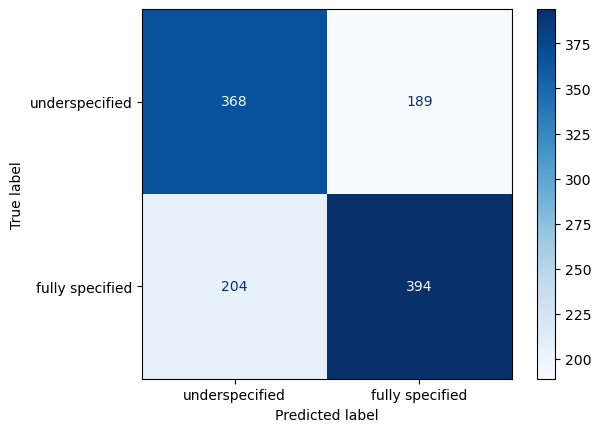

In [8]:
# If there are errors

result_df = pd.read_csv("DS14B_FS_UND_correct.csv")

print(classification_report(result_df["gold_judgment"], result_df['model_pred']))


judgment_gold = result_df['gold_judgment'].tolist()
judgment_model = result_df["model_pred"].tolist()

binary_labels = ['underspecified', 'fully specified']

cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

disp.plot(cmap='Blues')  # 可以调整 colormap

                 precision    recall  f1-score   support

fully specified       0.71      0.61      0.66       431
 underspecified       0.65      0.75      0.70       424

       accuracy                           0.68       855
      macro avg       0.68      0.68      0.68       855
   weighted avg       0.68      0.68      0.68       855



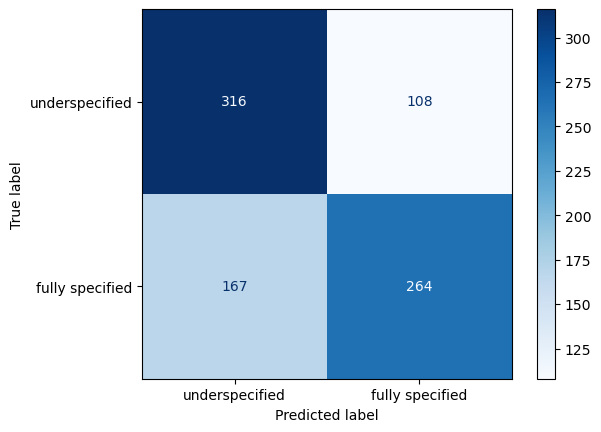

In [9]:
obtain_results_without("DS14B_FS_UND_correct.csv", 'AmbigQA')

# DeepSeek 32B

In [11]:
test_prompts = prepare_test_prompts(df_test_1155, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 1155
Generation complete: 1155 prompts
Average prompt length: 341 bytes (~85 tokens)

Analyze the following input user query:

{"query": "The idea that the united states was destined to extend westward across the continent?"}

Please provide your analysis in the following JSON format:

{"query": "The idea that the united states was destined to extend westward across the continent?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [12]:
test_df = run_experiment(test_prompts, df_test_1155)
test_df

100%|██████████| 231/231 [2:57:04<00:00, 46.00s/it]  

Respond content: The query "When a blood vessel is injured the first phase in hemostasis to occur is?" is fully specified because it provides all necessary details for a precise answer. It clearly specifies the scenar...
Respond content: The query "Who played the mohawk guy in road warrior?" is underspecified. 

**Step-by-Step Explanation:**

1. **Ambiguity in Character Reference:** The term "mohawk guy" is vague. The movie "Mad Max: ...
Respond content: The query "Who plays avery in when we first met?" is **underspecified**. 

**Reasoning:**
1. **Title Ambiguity:** The phrase "When We First Met" could refer to multiple works (e.g., a movie and a TV s...
Respond content: The query "Who plays astrid how to train your dragon?" is underspecified because it does not specify which part of the "How to Train Your Dragon" franchise the user is referring to. The series include...
Respond content: The query "Who won the battle of philippi civil war?" is fully specified. 

**Step-by-Step Explanat

,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
0,1787,The idea that the united states was destined t...,fully specified,AmbigQA,"Okay, so I need to figure out whether the user...",The query is underspecified because it lacks s...,underspecified
1,161,How many times french won the world cup?,fully specified,AmbigQA,"Okay, so I need to analyze whether the query ""...","```json\n{\n ""query"": ""How many times french ...",underspecified
2,1383,When was pink floyd's dark side of the moon re...,fully specified,AmbigQA,"Okay, so I need to determine whether the user'...","```json\n{\n ""query"": ""When was pink floyd's ...",fully specified
3,1111,When did leonardo da vinci finish painting the...,fully specified,AmbigQA,"Okay, so I need to figure out if the query ""Wh...",The query is fully specified as it clearly pro...,fully specified
4,1542,Who is the first speaker of national assembly ...,fully specified,AmbigQA,"Alright, I need to analyze whether the query ""...","```json\n{\n ""query"": ""Who is the first speak...",fully specified
...,...,...,...,...,...,...,...
1150,335,Is Pensacola sylvestris a multicellular organi...,fully specified,CLAMBER,"Okay, so I need to analyze the query: ""Is Pens...","```json\n{\n ""query"": ""Is Pensacola sylvestri...",underspecified
1151,337,What's the leaf mass per area of Larrea divari...,fully specified,CLAMBER,"Alright, I need to analyze whether the user's ...","```json\n{\n ""query"": ""What's the leaf mass p...",fully specified
1152,364,When did Patsyella make its last appearance in...,fully specified,CLAMBER,"Okay, so I need to determine whether the user'...","```json\n{\n ""query"": ""When did Patsyella mak...",fully specified
1153,276,What's the body mass of Salamandra salamandra?,fully specified,CLAMBER,"Alright, let's tackle this query. The user is ...","```json\n{\n ""query"": ""What's the body mass o...",underspecified


In [13]:
retrieve_results(test_df, "DS32B_FS_UND")

There are unrecognized labels.


                 precision    recall  f1-score   support

fully specified       0.70      0.54      0.61       598
 underspecified       0.60      0.75      0.67       557

       accuracy                           0.64      1155
      macro avg       0.65      0.65      0.64      1155
   weighted avg       0.65      0.64      0.64      1155



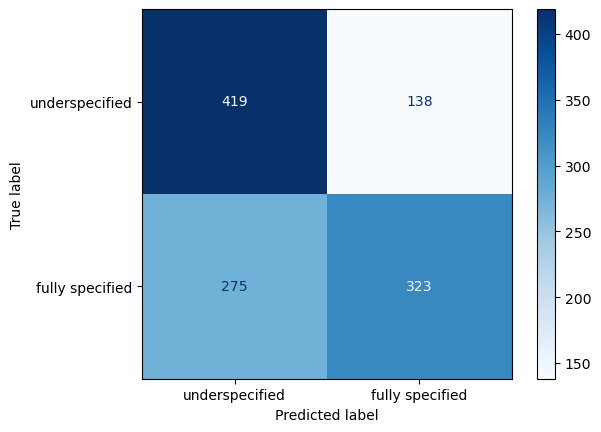

In [5]:
# If there are errors

result_df = pd.read_csv("DS32B_FS_UND_corrected.csv")

print(classification_report(result_df["gold_judgment"], result_df['model_pred']))


judgment_gold = result_df['gold_judgment'].tolist()
judgment_model = result_df["model_pred"].tolist()

binary_labels = ['underspecified', 'fully specified']

cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

disp.plot(cmap='Blues')  # 可以调整 colormap

                 precision    recall  f1-score   support

fully specified       0.75      0.52      0.61       431
 underspecified       0.63      0.82      0.71       424

       accuracy                           0.67       855
      macro avg       0.69      0.67      0.66       855
   weighted avg       0.69      0.67      0.66       855



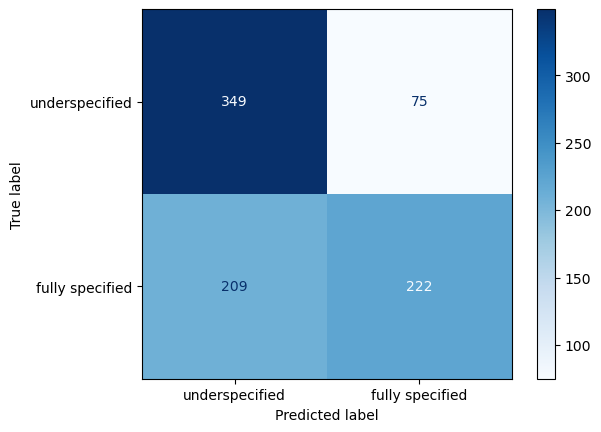

In [10]:
obtain_results_without("DS32B_FS_UND_corrected.csv", 'AmbigQA')

# DeepSeek V3 685B (API)

## Helper functions

In [8]:
import openai
import re
import time

client = openai.Client(
    base_url="https://api.deepseek.com", api_key="")



def batch_generate_responses_openai_V3(prompts, system_prompt=system_prompt,
                             temperature=0.7, max_new_tokens=8192, batch_size=5):
    """
    批量处理提示并使用DeepSeek V3模型生成回复

    参数:
        prompts (list): 提示列表
        system_prompt (str): 系统提示
        temperature (float): 温度参数，控制随机性
        max_new_tokens (int): 生成的最大token数
        batch_size (int): 批处理大小

    返回:
        list: 生成的回复列表
    """
    responses = []

    for i in tqdm(range(0, len(prompts), batch_size)):
        batch_prompts = prompts[i:i+batch_size]
        batch_responses = []

        for prompt in batch_prompts:
            try:
                response = client.chat.completions.create(
                    model="deepseek-chat",
                    messages=[
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": prompt},
                    ],
                    temperature=temperature,
                    max_tokens=max_new_tokens,
                )

                # 直接获取响应文本
                answer = response.choices[0].message.content
                batch_responses.append(answer)

            except Exception as e:
                print(f"处理提示时出错: {e}")
                batch_responses.append(None)  # 出错时返回None

                # 添加简单的重试逻辑
                if "rate limit" in str(e).lower():
                    print("达到速率限制，暂停5秒...")
                    time.sleep(5)

        responses.extend(batch_responses)
        # 在批次之间添加小延迟以避免速率限制
        time.sleep(0.2)

    return responses

def run_experiment(input_prompts, test_df):
  output = batch_generate_responses_openai_V3(input_prompts)
  df = test_df.copy()
  df['model_response'] = output
  processed_judgments = get_judgments_from_responses(output)
  df['model_pred'] = processed_judgments

  return df

def get_judgments_from_responses(responses: List[str]) -> List[Optional[str]]:
    """
    推荐的解析函数，结合了多种方法的优点
    """
    judgments = []

    for i, response in enumerate(responses):
        judgment = None

        try:
            # 方法1: 尝试直接解析JSON
            clean_response = response.strip()
            if clean_response.startswith('{') and clean_response.endswith('}'):
                data = json.loads(clean_response)
                judgment = data.get('judgment')
            else:
                # 方法2: 寻找JSON部分
                start_idx = clean_response.find('{')
                end_idx = clean_response.rfind('}')
                if start_idx != -1 and end_idx != -1:
                    json_part = clean_response[start_idx:end_idx+1]
                    data = json.loads(json_part)
                    judgment = data.get('judgment')

        except json.JSONDecodeError:
            # 方法3: 使用正则表达式作为后备
            pattern = r'"judgment"\s*:\s*"([^"]*)"'
            match = re.search(pattern, response)
            if match:
                judgment = match.group(1)

        if judgment is None:
            print(f"Warning: response {i} cannot retrieve judgment")
            print(f"Respond content: {response[:200]}...")
            judgment = "error"

        judgments.append(judgment)

    return judgments

def retrieve_results(result_df, output_name):
  processed_judgments = result_df['model_pred'].tolist()

  if "error" in processed_judgments:
    print("There are unrecognized labels.")
    result_df.to_csv(f'{output_name}_error.csv')
  else:
    print("No error found, directly process the data.")
    print(classification_report(result_df["gold_judgment"], result_df['model_pred']))
    result_df.to_csv(f'{output_name}.csv')

    judgment_gold = result_df['gold_judgment'].tolist()
    judgment_model = result_df["model_pred"].tolist()

    binary_labels = ['underspecified', 'fully specified']

    cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

    disp.plot(cmap='Blues')  # 可以调整 colormap

def prepare_test_prompts(test_df, task_text, learning_df=None, instruction_text=None, theory=False):
  print("Start preparing prompts...")
  if learning_df is not None and instruction_text is not None:
    print(f"# learning samples: {len(learning_df)}")
    examples = []
    if theory:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "reasoning": row['reasoning'],
                "category": row['category'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text
    else:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text

  else:
    base_prompt = task_text

  print(f"# Testing data points: {len(test_df)}")
  test_prompts = []
  for _, row in test_df.iterrows():
    query = row['request']
    complete_prompt = base_prompt.replace("TARGET", query)
    test_prompts.append(complete_prompt)

  print(f"Generation complete: {len(test_prompts)} prompts")

  avg_length = sum(len(p) for p in test_prompts) // len(test_prompts)
  print(f"Average prompt length: {avg_length:,} bytes (~{avg_length//4:,} tokens)")

  return test_prompts

## pilot

In [9]:
test_prompts = prepare_test_prompts(df_few_shots, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 12
Generation complete: 12 prompts
Average prompt length: 349 bytes (~87 tokens)

Analyze the following input user query:

{"query": "When did the nuclear accident happen?"}

Please provide your analysis in the following JSON format:

{"query": "When did the nuclear accident happen?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [10]:
test_df = run_experiment(test_prompts, df_few_shots)
test_df

100%|██████████| 3/3 [01:53<00:00, 37.69s/it]


,request,gold_analysis,gold_thought,gold_category,gold_judgment,direct_source,model_response,model_pred
0,When did the nuclear accident happen?,"{""predicate"": ""happen"", ""argument_time"": ""when...","The predicate ""happen"" is specified; its argum...",underspecified referential/indexical argument,underspecified,CoCoNot,"```json\n{\n ""query"": ""When did the nuclear a...",underspecified
1,I need help picking out a professional wardrob...,"{""predicate"": ""provide"", ""argument_agent"": ""yo...","The predicate ""provide"" is specified; its argu...",underspecified quantified argument,underspecified,IN3,"```json\n{\n ""query"": ""I need help picking ou...",underspecified
2,When did the apple tv 4k come out?,"{""predicate"": ""come out"", ""argument_time"": ""wh...","The predicate ""come out"" is underspecified bec...",underspecified predicate,underspecified,AmbigQA,"```json\n{\n ""query"": ""When did the apple tv ...",fully specified
3,Who sings i love rock 'n' roll? ...,"{""predicate"": ""sings"", ""argument_agent"": ""who""...","The predicate ""sings"" is specified; its argume...",underspecified argument concept,underspecified,AmbigQA,"```json\n{\n ""query"": ""Who sings i love rock ...",fully specified
4,Where does the new fallout game take place?,"{""predicate"": ""take place"", ""argument_location...","The predicate ""take place"" is underspecified b...",multi-sourced underspecification,underspecified,AmbigQA,"```json\n{\n ""query"": ""Where does the new fal...",underspecified
5,Who is the existing prime minister?,"{""predicate"": ""existing prime minister"", ""argu...","The predicate ""existing prime minister"" is spe...",missing argument,underspecified,CoCoNot,"```json\n{\n ""query"": ""Who is the existing pr...",underspecified
6,Who played the king in game of thrones season 1?,"{""predicate"": ""played"", ""argument_agent"": ""who...","The predicate ""played"" is specified; its argum...",fully specified request,fully specified,AmbigQA,"```json\n{\n ""query"": ""Who played the king in...",fully specified
7,Who plays henry tudor in the white princess?,"{""predicate"": ""plays"", ""argument_agent"": ""who""...","The predicate ""plays"" is specified; its argume...",fully specified request,fully specified,AmbigQA,"```json\n{\n ""query"": ""Who plays henry tudor ...",fully specified
8,Who won the contest to design the capitol buil...,"{""predicate"": ""won"", ""argument_agent"": ""who"", ...","The predicate ""won"" is specified; its argument...",fully specified request,fully specified,AmbigQA,"```json\n{\n ""query"": ""Who won the contest to...",underspecified
9,How many daughters do George Washington have?,"{""predicate: ""have"", ""argument_theme"": ""how ma...","The predicate ""have"" is specified; its argumen...",fully specified request,fully specified,IN3,"```json\n{\n ""query"": ""How many daughters do ...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.71      0.83      0.77         6
 underspecified       0.80      0.67      0.73         6

       accuracy                           0.75        12
      macro avg       0.76      0.75      0.75        12
   weighted avg       0.76      0.75      0.75        12



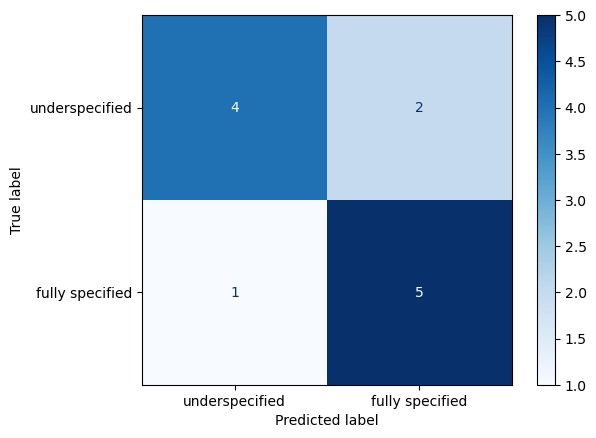

In [11]:
retrieve_results(test_df, "DS_V3_FS_UND_pilot")

## implementation

In [ ]:
test_prompts = prepare_test_prompts(df_test_1155, task_FS_UND)
print(test_prompts[0])

In [ ]:
test_df = run_experiment(test_prompts, df_test_1155)
test_df

In [ ]:
retrieve_results(test_df, "DS_V3_FS_UND")

# DeepSeek R1 685B (API)

In [12]:
import openai
import re
import time

client = openai.Client(
    base_url="https://api.deepseek.com", api_key=" ")


def batch_generate_responses_openai_R1(prompts, system_prompt=system_prompt,
                             temperature=0.7, max_new_tokens=8192, batch_size=5):
    """
    批量处理提示并使用DeepSeek Reasoner模型生成回复，获取推理内容和最终回答

    参数:
        prompts (list): 提示列表
        system_prompt (str, optional): 系统提示，注意DeepSeek Reasoner可能不使用系统提示
        temperature (float): 温度参数，控制随机性
        max_new_tokens (int): 生成的最大token数
        batch_size (int): 批处理大小

    返回:
        tuple: 包含两个列表 (responses, reasonings)，分别是最终回答和推理过程
    """
    responses = []
    reasonings = []

    for i in tqdm(range(0, len(prompts), batch_size)):
        batch_prompts = prompts[i:i+batch_size]
        batch_responses = []
        batch_reasonings = []

        for prompt in batch_prompts:
            try:
                # 准备消息，如果有系统提示则添加
                messages = []
                if system_prompt:
                    messages.append({"role": "system", "content": system_prompt})
                messages.append({"role": "user", "content": prompt})

                response = client.chat.completions.create(
                    model="deepseek-reasoner",
                    messages=messages,
                    temperature=temperature,
                    max_tokens=max_new_tokens,
                )

                # 从响应中直接获取内容和推理内容
                content = response.choices[0].message.content
                reasoning_content = response.choices[0].message.reasoning_content

                batch_responses.append(content)
                batch_reasonings.append(reasoning_content)

            except Exception as e:
                print(f"处理提示时出错: {e}")
                # 检查是否是因为response格式问题
                if "object has no attribute 'reasoning_content'" in str(e):
                    print("注意: API响应中没有'reasoning_content'字段。请确认您使用的是DeepSeek Reasoner模型。")
                    # 尝试只获取常规内容
                    try:
                        content = response.choices[0].message.content
                        batch_responses.append(content)
                        batch_reasonings.append(None)  # 没有推理内容
                    except:
                        batch_responses.append(None)
                        batch_reasonings.append(None)
                else:
                    batch_responses.append(None)
                    batch_reasonings.append(None)

                # 添加简单的重试逻辑
                if "rate limit" in str(e).lower():
                    print("达到速率限制，暂停5秒...")
                    time.sleep(5)

        responses.extend(batch_responses)
        reasonings.extend(batch_reasonings)
        # 在批次之间添加小延迟以避免速率限制
        time.sleep(0.5)

    return responses, reasonings

def run_experiment(input_prompts, test_df):
  output = batch_generate_responses_openai_R1(input_prompts)
  df = test_df.copy()
  df['thinking'] = output[1]
  df['model_response'] = output[0]
  to_process = output[0]
  processed_judgments = get_judgments_from_responses(to_process)
  df['model_pred'] = processed_judgments

  return df

def get_judgments_from_responses(responses: List[str]) -> List[Optional[str]]:
    """
    推荐的解析函数，结合了多种方法的优点
    """
    judgments = []

    for i, response in enumerate(responses):
        judgment = None

        try:
            # 方法1: 尝试直接解析JSON
            clean_response = response.strip()
            if clean_response.startswith('{') and clean_response.endswith('}'):
                data = json.loads(clean_response)
                judgment = data.get('judgment')
            else:
                # 方法2: 寻找JSON部分
                start_idx = clean_response.find('{')
                end_idx = clean_response.rfind('}')
                if start_idx != -1 and end_idx != -1:
                    json_part = clean_response[start_idx:end_idx+1]
                    data = json.loads(json_part)
                    judgment = data.get('judgment')

        except json.JSONDecodeError:
            # 方法3: 使用正则表达式作为后备
            pattern = r'"judgment"\s*:\s*"([^"]*)"'
            match = re.search(pattern, response)
            if match:
                judgment = match.group(1)

        if judgment is None:
            print(f"Warning: response {i} cannot retrieve judgment")
            print(f"Respond content: {response[:200]}...")
            judgment = "error"

        judgments.append(judgment)

    return judgments

def retrieve_results(result_df, output_name):
  processed_judgments = result_df['model_pred'].tolist()

  if "error" in processed_judgments:
    print("There are unrecognized labels.")
    result_df.to_csv(f'{output_name}_error.csv')
  else:
    print("No error found, directly process the data.")
    print(classification_report(result_df["gold_judgment"], result_df['model_pred']))
    result_df.to_csv(f'{output_name}.csv')

    judgment_gold = result_df['gold_judgment'].tolist()
    judgment_model = result_df["model_pred"].tolist()

    binary_labels = ['underspecified', 'fully specified']

    cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

    disp.plot(cmap='Blues')  # 可以调整 colormap

def prepare_test_prompts(test_df, task_text, learning_df=None, instruction_text=None, theory=False):
  print("Start preparing prompts...")
  if learning_df is not None and instruction_text is not None:
    print(f"# learning samples: {len(learning_df)}")
    examples = []
    if theory:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "reasoning": row['reasoning'],
                "category": row['category'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text
    else:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text

  else:
    base_prompt = task_text

  print(f"# Testing data points: {len(test_df)}")
  test_prompts = []
  for _, row in test_df.iterrows():
    query = row['request']
    complete_prompt = base_prompt.replace("TARGET", query)
    test_prompts.append(complete_prompt)

  print(f"Generation complete: {len(test_prompts)} prompts")

  avg_length = sum(len(p) for p in test_prompts) // len(test_prompts)
  print(f"Average prompt length: {avg_length:,} bytes (~{avg_length//4:,} tokens)")

  return test_prompts

## pilot

In [13]:
test_prompts = prepare_test_prompts(df_few_shots, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 12
Generation complete: 12 prompts
Average prompt length: 349 bytes (~87 tokens)

Analyze the following input user query:

{"query": "When did the nuclear accident happen?"}

Please provide your analysis in the following JSON format:

{"query": "When did the nuclear accident happen?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [14]:
test_df = run_experiment(test_prompts, df_few_shots)
test_df

100%|██████████| 3/3 [05:53<00:00, 117.93s/it]


,request,gold_analysis,gold_thought,gold_category,gold_judgment,direct_source,thinking,model_response,model_pred
0,When did the nuclear accident happen?,"{""predicate"": ""happen"", ""argument_time"": ""when...","The predicate ""happen"" is specified; its argum...",underspecified referential/indexical argument,underspecified,CoCoNot,"Alright, I need to determine whether the user'...","{\n ""query"": ""When did the nuclear accident h...",underspecified
1,I need help picking out a professional wardrob...,"{""predicate"": ""provide"", ""argument_agent"": ""yo...","The predicate ""provide"" is specified; its argu...",underspecified quantified argument,underspecified,IN3,"Alright, I'm looking at this user query about ...","{\n ""query"": ""I need help picking out a profe...",underspecified
2,When did the apple tv 4k come out?,"{""predicate"": ""come out"", ""argument_time"": ""wh...","The predicate ""come out"" is underspecified bec...",underspecified predicate,underspecified,AmbigQA,"Alright, let me tackle this problem step by st...","{\n ""query"": ""When did the apple tv 4k come o...",underspecified
3,Who sings i love rock 'n' roll? ...,"{""predicate"": ""sings"", ""argument_agent"": ""who""...","The predicate ""sings"" is specified; its argume...",underspecified argument concept,underspecified,AmbigQA,"Alright, let's tackle this query. The user wan...","{\n ""query"": ""Who sings i love rock 'n' roll?...",fully specified
4,Where does the new fallout game take place?,"{""predicate"": ""take place"", ""argument_location...","The predicate ""take place"" is underspecified b...",multi-sourced underspecification,underspecified,AmbigQA,"Alright, I'm looking at this user query analys...","{\n ""query"": ""Where does the new fallout game...",fully specified
5,Who is the existing prime minister?,"{""predicate"": ""existing prime minister"", ""argu...","The predicate ""existing prime minister"" is spe...",missing argument,underspecified,CoCoNot,"Alright, let's tackle this problem. The user w...","{""query"": ""Who is the existing prime minister?...",underspecified
6,Who played the king in game of thrones season 1?,"{""predicate"": ""played"", ""argument_agent"": ""who...","The predicate ""played"" is specified; its argum...",fully specified request,fully specified,AmbigQA,"Alright, let's tackle this problem step by ste...","{\n ""query"": ""Who played the king in game of ...",fully specified
7,Who plays henry tudor in the white princess?,"{""predicate"": ""plays"", ""argument_agent"": ""who""...","The predicate ""plays"" is specified; its argume...",fully specified request,fully specified,AmbigQA,"Alright, let's tackle this problem. The user w...","{""query"": ""Who plays henry tudor in the white ...",fully specified
8,Who won the contest to design the capitol buil...,"{""predicate"": ""won"", ""argument_agent"": ""who"", ...","The predicate ""won"" is specified; its argument...",fully specified request,fully specified,AmbigQA,"Alright, let's tackle this problem step by ste...","{\n ""query"": ""Who won the contest to design t...",underspecified
9,How many daughters do George Washington have?,"{""predicate: ""have"", ""argument_theme"": ""how ma...","The predicate ""have"" is specified; its argumen...",fully specified request,fully specified,IN3,"Alright, let's tackle this problem step by ste...","{\n ""query"": ""How many daughters do George Wa...",underspecified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.60      0.50      0.55         6
 underspecified       0.57      0.67      0.62         6

       accuracy                           0.58        12
      macro avg       0.59      0.58      0.58        12
   weighted avg       0.59      0.58      0.58        12



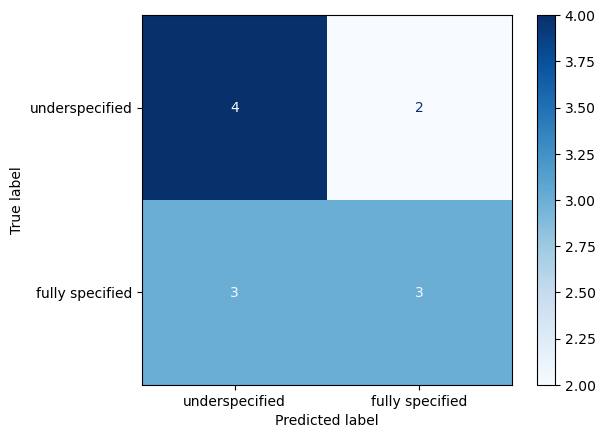

In [15]:
retrieve_results(test_df, "DS_R1_FS_UND_pilot")

## implementation

In [ ]:
test_prompts = prepare_test_prompts(df_test_1155, task_FS_UND)
print(test_prompts[0])

In [ ]:
test_df = run_experiment(test_prompts, df_test_1155)
test_df

In [ ]:
retrieve_results(test_df, "DS_R1_FS_UND")